# Anomaly detection in time series

### Submitted by: Noa Kotler, Nitzan Tal

## Note: This notebook needs to be run as it contains interact widgest. Thank you! 
#### (It takes at least 10 minutes)

In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd

# Anomalies

In this homework we will look at some simple examples of detecting anomalies in time series. But first, let's try to define, what anomaly is.

In general, **anomaly** is an observable behaviour of the system, which contradicts the underlying dynamics, which we believe is driving the system. Of course, any observable, normal or anomalous, is generated by underlying system dynamics. The real reason we consider some behaviours as normal and some as anomalous is that we use not a real dynamics to describe the system, but either some model, or we want system to demostrate certain desired behaviour.

For example:

- unusually high power consumption in electrical grid may be caused by unusual weather conditions for a certain season, and is thus an absolutely explainable, but grid operator still considers this situation as an anomaly, because unusually high consumption is not a desirable behaviour,
- presense of unusual patterns in sensor reading of industrial equipment may be an indication of some failure coming. In this case, anomaly is not manifested as some extremely high or low way, but rather as an unusual pattern.

In this homework we will consider two datasets:

- [hourly energy consumption data from PJM transmission operator](https://www.kaggle.com/robikscube/hourly-energy-consumption),
- ECG data from [MIT-BIH Arrhythmia Database](https://www.kaggle.com/mondejar/mitbih-database).

# Data

For the first exercise, we will take specific area, served by Commonwealth Edison energy producer. The area is Chicago and part of Illinois. We will look at the data to understand, when consumption is anomalous and will try to explain this anomalies to some extent.

In [3]:
def load_energy_data():
    data = pd.read_csv('COMED_hourly.csv',
                       parse_dates=["Datetime"],
                       index_col="Datetime")

    # Let's clean-up the field a bit first:
    data.rename({"COMED_MW":"cons_mw"}, axis=1, inplace=True)
    data.index.name = "dt"
    data.head()
    
    # sort the data by time
    data=data.sort_index()
    
    return data

## Quick exploration

Data definitely demostrates strong seasonality with consumption being higher at summer (air conditioning, apperantly) and during winter (electrical heating, lights etc.):

In [4]:
data = load_energy_data()

data.head()

,cons_mw
dt,
2011-01-01 01:00:00,9631.0
2011-01-01 02:00:00,9273.0
2011-01-01 03:00:00,9011.0
2011-01-01 04:00:00,8741.0
2011-01-01 05:00:00,8694.0


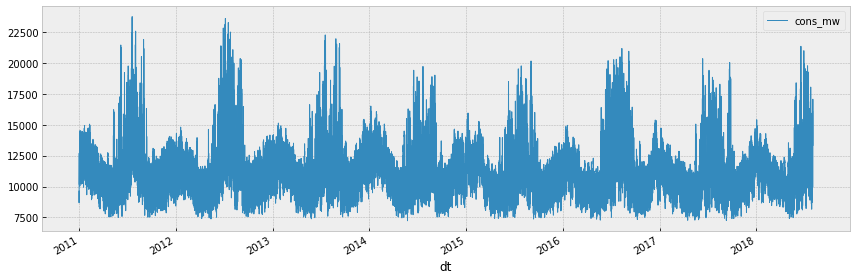

In [5]:
plt.figure(figsize=(12,4))
data.plot(linewidth=1, ax=plt.gca())
plt.tight_layout()

If we try to calculate rolling average of the data, we will fail, cause original data is not ordered:

In [6]:
# data=data.sort_index()
data.rolling("7D").mean()

,cons_mw
dt,
2011-01-01 01:00:00,9631.000000
2011-01-01 02:00:00,9452.000000
2011-01-01 03:00:00,9305.000000
2011-01-01 04:00:00,9164.000000
2011-01-01 05:00:00,9070.000000
...,...
2018-08-02 20:00:00,12035.815476
2018-08-02 21:00:00,12045.607143
2018-08-02 22:00:00,12054.297619


# Naive anomalies detection

The first and the most simple way to catch unusually high or low values is to just look at rolling average and rolling standard deviation. The assumation is that for a reasonably short period we can use usual statistical approaches, and to say
> if it's outside 3$\sigma$, it's an anomaly

is still somewhat reliable. Let's look at the data at a weekly scale:

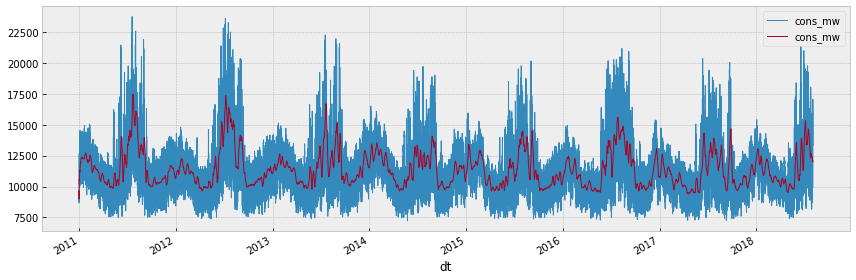

In [7]:
plt.figure(figsize=(12,4))

data.plot(linewidth=1, ax=plt.gca())

data.rolling("7D").mean().plot(linewidth=1, ax=plt.gca())

plt.legend(loc=0)
plt.tight_layout()

If we look at the same data on a monthly scale and add "normal" range ($3\sigma$ from rolling average in any direction), we'll start to see hours, which go to high:

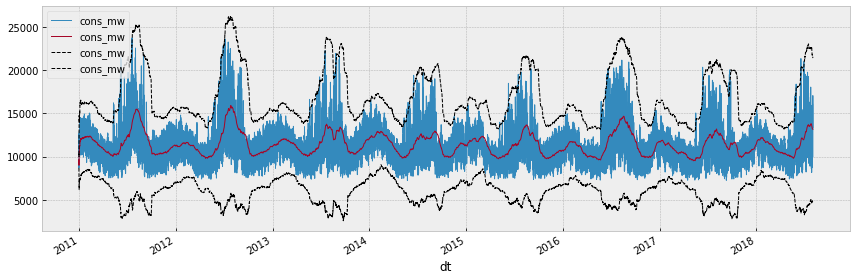

In [8]:
plt.figure(figsize=(12,4))

data.plot(linewidth=1, ax=plt.gca())

(data
 .rolling("30D")
 .mean()
 .plot(linewidth=1, ax=plt.gca(), label="rolling average"))

((data.rolling("30D").mean()+3*data.rolling("30D").std())
 .plot(linewidth=1, linestyle="--", color="k", ax=plt.gca(), label="rolling average"))

((data.rolling("30D").mean()-3*data.rolling("30D").std())
 .plot(linewidth=1, linestyle="--", color="k", ax=plt.gca(), label="rolling average"))

plt.legend(loc=0)
plt.tight_layout()

Let's create a funtion, which searches for such points and creates new dataframe with anomaly indication:

In [9]:
def detect_anomalies(series, window, factor):
    """Mark all the anomalies, i.e. points, which are outside of `factor*std` range."""

    series_mean = series.rolling(window).mean()
    series_std = series.rolling(window).std()

    result = pd.concat([series,
                        series_mean.rename("_".join([series.name, "rmean"]))],
                       axis=1)
    result = result.join(series_std.rename("_".join([series.name, "rstd"])))
    anomaly = ((series-series_mean)>factor*series_std).astype(int)
    result = result.join(anomaly.rename("anomaly"))
    return result

In [10]:
data_an = detect_anomalies(data["cons_mw"], "30D", 3.)

In [11]:
data_an.head()

,cons_mw,cons_mw_rmean,cons_mw_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,9631.0,9631.0,NaN,0
2011-01-01 02:00:00,9273.0,9452.0,253.144228,0
2011-01-01 03:00:00,9011.0,9305.0,311.236245,0
2011-01-01 04:00:00,8741.0,9164.0,379.608570,0
2011-01-01 05:00:00,8694.0,9070.0,390.201230,0


In [12]:
def plot_anomalies(df, d_col, m_col, s_col, a_col, factor):
    """Plot data and annotations."""

    plt.figure(figsize=(12,4))

    # Plot original data
    df[d_col].plot(linewidth=1, ax=plt.gca())

    # Plot rolling average
    df[m_col].plot(linewidth=1, ax=plt.gca())

    # Plot "normal" range
    (df[m_col]+factor*df[s_col]).plot(linewidth=1, c="k", linestyle="--", ax=plt.gca())
    (df[m_col]-factor*df[s_col]).plot(linewidth=1, c="k", linestyle="--", ax=plt.gca())

    # Plo anomalies
    df.loc[df[a_col]==1, d_col].plot(linewidth=0,
                                     marker="x",
                                     markersize=2,
                                     c="yellow", linestyle="--",  ax=plt.gca())


    plt.tight_layout()

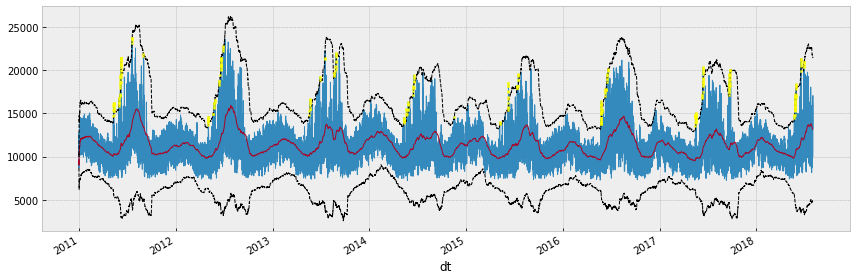

In [13]:
plot_anomalies(data_an, "cons_mw", "cons_mw_rmean", "cons_mw_rstd", "anomaly", 3)

Although some of the caught anomalies look ok, we immediately can spot several problems:
    
- we definitely underestimate the upper bound of the range, when rolling average goes up very fast,
- we definitely overestimate the upper bound of the range, when rolling average goes down very fast.

This all happens because rolling average is "delayed" relative to underlying time series. Another, probably more severe, problem is non-stationarity, and especially seasonality. Depending on the structure, by doing such a naive anomaly detection we may miss a lot of real anomalies. Can we do better?

# Extracting trends and seasonality

To make our anomaly search more robust, we can remove trend (if any) and seasonality from the time series:

$$series = trend + seasonality + residuals$$.

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [15]:
result = seasonal_decompose(data["cons_mw"], period=365*24)
result.resid

dt
2011-01-01 01:00:00   NaN
2011-01-01 02:00:00   NaN
2011-01-01 03:00:00   NaN
2011-01-01 04:00:00   NaN
2011-01-01 05:00:00   NaN
                       ..
2018-08-02 20:00:00   NaN
2018-08-02 21:00:00   NaN
2018-08-02 22:00:00   NaN
2018-08-02 23:00:00   NaN
2018-08-03 00:00:00   NaN
Name: resid, Length: 66497, dtype: float64

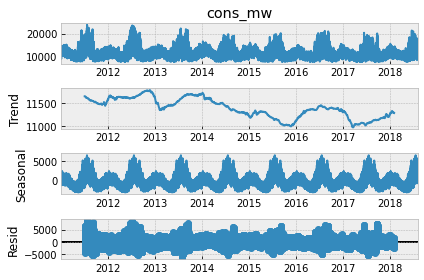

In [16]:
result.plot()
plt.show()

Looks interesting: we have very pronounced seasonality and a lot of information, not covered by season at all (residuals are of the same range, as seasonal component). This may drive us to conclusion, that we can use residuals as the new series for anomaly detection. Let's try.

In [17]:
residual_anomalies = detect_anomalies(result.resid.rename("cons_mw_res"), "30D", 3.)

In [18]:
residual_anomalies

,cons_mw_res,cons_mw_res_rmean,cons_mw_res_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,NaN,NaN,NaN,0
2011-01-01 02:00:00,NaN,NaN,NaN,0
2011-01-01 03:00:00,NaN,NaN,NaN,0
2011-01-01 04:00:00,NaN,NaN,NaN,0
2011-01-01 05:00:00,NaN,NaN,NaN,0
...,...,...,...,...
2018-08-02 20:00:00,NaN,NaN,NaN,0
2018-08-02 21:00:00,NaN,NaN,NaN,0
2018-08-02 22:00:00,NaN,NaN,NaN,0


In [19]:
data_an.iloc[:, :-1]

,cons_mw,cons_mw_rmean,cons_mw_rstd
dt,,,
2011-01-01 01:00:00,9631.0,9631.000000,NaN
2011-01-01 02:00:00,9273.0,9452.000000,253.144228
2011-01-01 03:00:00,9011.0,9305.000000,311.236245
2011-01-01 04:00:00,8741.0,9164.000000,379.608570
2011-01-01 05:00:00,8694.0,9070.000000,390.201230
...,...,...,...
2018-08-02 20:00:00,16437.0,13179.456944,2756.544596
2018-08-02 21:00:00,15590.0,13176.827778,2753.335103
2018-08-02 22:00:00,15086.0,13174.450000,2750.941713


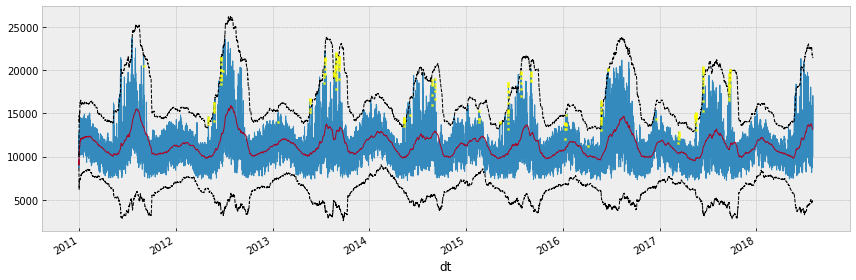

In [20]:
plot_anomalies(data_an.iloc[:, :-1].join(residual_anomalies["anomaly"]),
               "cons_mw", "cons_mw_rmean", "cons_mw_rstd", "anomaly", 3)

What is interesting, is that locations anomalies are different.

# Next steps

Can we somehow explain the anomalies? Or validate them? Yes, we can. Using the [historical weather dataset](https://www.kaggle.com/selfishgene/historical-hourly-weather-data#city_attributes.csv), we can look, whether temperature explains anomalies to some extent and then improve our anomaly detection algrithm.

In [21]:
temp_data = pd.read_csv("temperature.csv", parse_dates=["datetime"],
                        usecols=["datetime", "Chicago"], index_col="datetime")
temp_data.head()

,Chicago
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,284.010000
2012-10-01 14:00:00,284.054691
2012-10-01 15:00:00,284.177412
2012-10-01 16:00:00,284.300133


In [22]:
data_an

,cons_mw,cons_mw_rmean,cons_mw_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,9631.0,9631.000000,NaN,0
2011-01-01 02:00:00,9273.0,9452.000000,253.144228,0
2011-01-01 03:00:00,9011.0,9305.000000,311.236245,0
2011-01-01 04:00:00,8741.0,9164.000000,379.608570,0
2011-01-01 05:00:00,8694.0,9070.000000,390.201230,0
...,...,...,...,...
2018-08-02 20:00:00,16437.0,13179.456944,2756.544596,0
2018-08-02 21:00:00,15590.0,13176.827778,2753.335103,0
2018-08-02 22:00:00,15086.0,13174.450000,2750.941713,0


,Chicago,cons_mw,cons_mw_rmean,cons_mw_rstd,anomaly
2012-10-01 12:00:00,NaN,11302.0,11047.650000,2393.575191,0.0
2012-10-01 13:00:00,284.010000,11426.0,11045.597222,2392.614522,0.0
2012-10-01 14:00:00,284.054691,11522.0,11043.711111,2391.701526,0.0
2012-10-01 15:00:00,284.177412,11574.0,11042.036111,2390.906017,0.0
2012-10-01 16:00:00,284.300133,11489.0,11040.330556,2390.147395,0.0
...,...,...,...,...,...
2017-11-29 20:00:00,281.340000,12171.0,10455.314840,1211.742030,0.0
2017-11-29 21:00:00,281.690000,11998.0,10455.672677,1212.159956,0.0
2017-11-29 22:00:00,281.070000,11681.0,10455.969487,1212.434103,0.0
2017-11-29 23:00:00,280.060000,11148.0,10456.199723,1212.549889,0.0


,Chicago,cons_mw,cons_mw_rmean,cons_mw_rstd,anomaly,anomaly_res
2012-10-01 12:00:00,NaN,11302.0,11047.650000,2393.575191,0.0,0.0
2012-10-01 13:00:00,284.010000,11426.0,11045.597222,2392.614522,0.0,0.0
2012-10-01 14:00:00,284.054691,11522.0,11043.711111,2391.701526,0.0,0.0
2012-10-01 15:00:00,284.177412,11574.0,11042.036111,2390.906017,0.0,0.0
2012-10-01 16:00:00,284.300133,11489.0,11040.330556,2390.147395,0.0,0.0
...,...,...,...,...,...,...
2017-11-29 20:00:00,281.340000,12171.0,10455.314840,1211.742030,0.0,0.0
2017-11-29 21:00:00,281.690000,11998.0,10455.672677,1212.159956,0.0,0.0
2017-11-29 22:00:00,281.070000,11681.0,10455.969487,1212.434103,0.0,0.0
2017-11-29 23:00:00,280.060000,11148.0,10456.199723,1212.549889,0.0,0.0


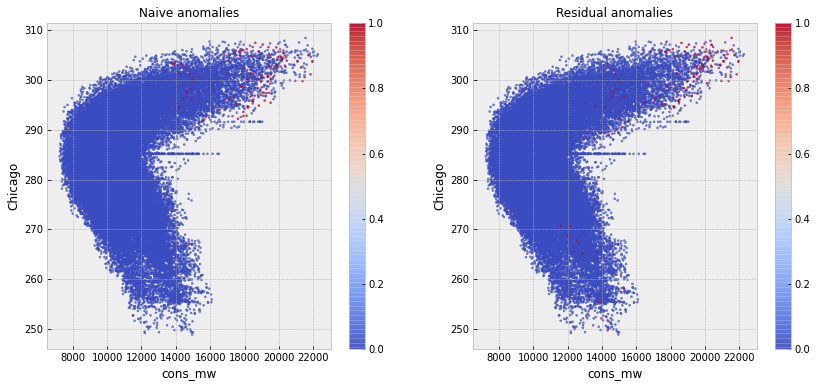

In [23]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
naive_anomalies = temp_data.join(data_an)
naive_anomalies.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Naive anomalies", fontsize=12)

display(naive_anomalies)

plt.subplot(1,2,2)
naive_anomalies = naive_anomalies.join(residual_anomalies["anomaly"], rsuffix="_res")
naive_anomalies.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly_res,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Residual anomalies", fontsize=12);

display(naive_anomalies)

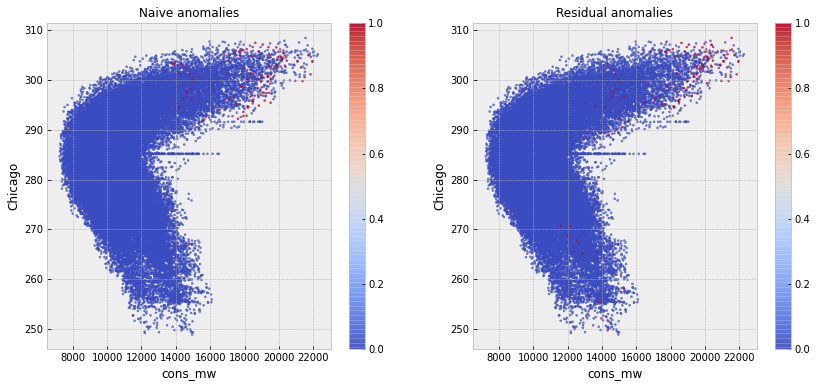

In [24]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
naive_anomalies = temp_data.join(data_an)
naive_anomalies.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Naive anomalies", fontsize=12)

plt.subplot(1,2,2)
naive_anomalies = naive_anomalies.join(residual_anomalies["anomaly"], rsuffix="_res")
naive_anomalies.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly_res,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Residual anomalies", fontsize=12);

Btw, can you extract season (summer/winter) from this images? Try to play with some clustering here.

In [25]:
from sklearn.cluster import KMeans

print('missing values - ', naive_anomalies.isna().any(axis=1).sum())
naive_anomalies_2 = naive_anomalies.dropna(axis='index')
subset = naive_anomalies_2.loc[:, ["Chicago","cons_mw"]]


missing values -  10


Text(0.5, 1.0, 'Seasons')

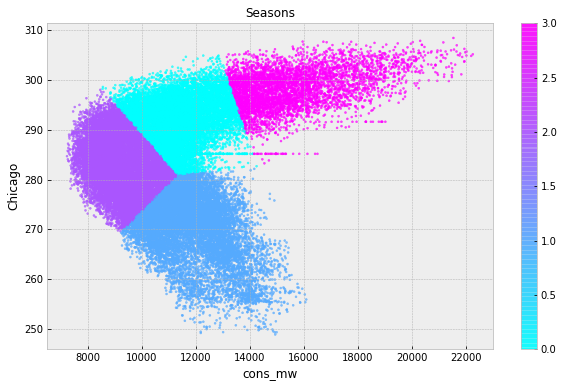

In [26]:
from sklearn.preprocessing import StandardScaler

normalized_data = StandardScaler().fit_transform(subset.loc[:, ["Chicago","cons_mw"]].values)
y_pred_KMeans = KMeans(4).fit_predict(normalized_data)

plt.figure(figsize=(10,6))
naive_anomalies_2.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=y_pred_KMeans,
                     cmap=plt.cm.cool, ax=plt.gca())
plt.title("Seasons", fontsize=12)



Text(0.5, 1.0, 'Seasons')

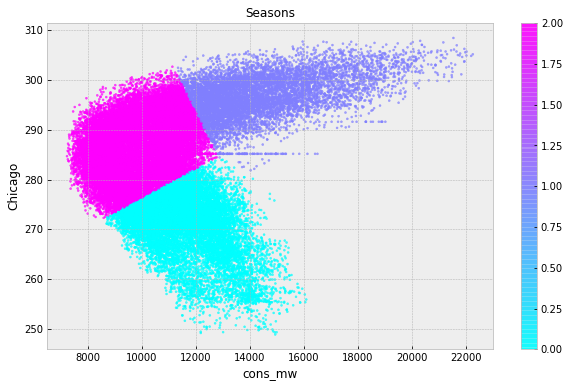

In [27]:
y_pred_KMeans = KMeans(3).fit_predict(normalized_data)

plt.figure(figsize=(10,6))
naive_anomalies_2.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=y_pred_KMeans,
                     cmap=plt.cm.cool, ax=plt.gca())
plt.title("Seasons", fontsize=12)




***
three seasons make more sense as spring and autumn both have similar tempertures. We can see the summer in the top cluster and winter as the lower one 
***

## Intermediate conclusions

We can make two conslusions from the plots above:

- temperature alone is a strong influencer of energy consumption,
- thus, some of the anomalies, that we detected looking only at consumption, are perfectly ok, if you add temperature into consideration.

Let's improve our detection approach, and look at both consumption and temperature. For this, we will use algorithm called Local Outlier Factor detection. In a simple terms, it looks at local density, and tryis to estimate, how strongly a point is embedded into the data.

In [28]:
from sklearn.neighbors import LocalOutlierFactor

In [29]:
en_temp = temp_data.join(data_an)[["Chicago", "cons_mw"]]

In [30]:
en_temp = en_temp[~en_temp.isnull().any(axis=1)]
en_temp

,Chicago,cons_mw
2012-10-01 13:00:00,284.010000,11426.0
2012-10-01 14:00:00,284.054691,11522.0
2012-10-01 15:00:00,284.177412,11574.0
2012-10-01 16:00:00,284.300133,11489.0
2012-10-01 17:00:00,284.422855,11309.0
...,...,...
2017-11-29 20:00:00,281.340000,12171.0
2017-11-29 21:00:00,281.690000,11998.0
2017-11-29 22:00:00,281.070000,11681.0
2017-11-29 23:00:00,280.060000,11148.0


Let's try default parameters first:

In [31]:
detector = LocalOutlierFactor()
factors = detector.fit_predict(en_temp)

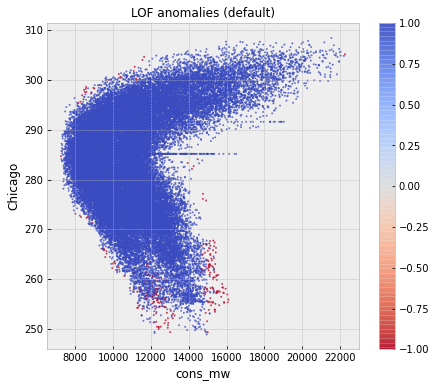

In [32]:

plt.figure(figsize=(7,6))

en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c=factors,
                     cmap=plt.cm.coolwarm_r, ax=plt.gca())
plt.title("LOF anomalies (default)", fontsize=12);

Not that bad, but it looks like our detector is a bit too harsh. Let's make it softer:

In [33]:
def run_LOF(contamination = 0.025, n_neighbors=10):

    print(f' running LOF with contamination = {contamination}, n_neighbors = {n_neighbors}')
    soft_detector = LocalOutlierFactor(contamination=contamination, n_neighbors=n_neighbors)
    factors = soft_detector.fit_predict(en_temp)
    plt.figure(figsize=(7,6))

    en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c=factors,
                         cmap=plt.cm.coolwarm_r, ax=plt.gca())
    plt.title("LOF anomalies", fontsize=12);

In [34]:
import ipywidgets as widgets
from ipywidgets import interact_manual, interact, fixed

cont =  widgets.FloatSlider(min=0.005, max = 0.2, step = 0.005, value=0.025);
neighbors = widgets.IntSlider(min=1, max = 50, value=10);


interact(run_LOF, contamination = cont, n_neighbors = neighbors)


interactive(children=(FloatSlider(value=0.025, description='contamination', max=0.2, min=0.005, step=0.005), I…

<function __main__.run_LOF(contamination=0.025, n_neighbors=10)>

Contamination parameter defines, how many outliers we have in the data. `0.025` means `once in 40 hours`, which is reasonable, but depends, of course, on which grid operator we consider.

Now that we looked at basics of outlier/anomaly detection, you can play with it further, for example, try IsolationForest algorithm. You may benefit from reading the discussion on how outlier is different from novelty at [`sklearn` User guide](https://scikit-learn.org/stable/modules/outlier_detection.html).

In [35]:
# isolation forest:

from sklearn.ensemble import IsolationForest

def run_isolation_forest(contamination = 0.025):

    print(f' running Isolation Forest with contamination = {contamination}')

    isol_forest = IsolationForest( random_state=0, contamination=contamination, n_jobs=4) 
    isol_forest.fit(en_temp)

    pred = isol_forest.predict(en_temp)

    en_temp['if_anomaly']=pred

    outliers=en_temp.loc[en_temp['if_anomaly']== -1]
    outlier_index=list(outliers.index)

    #Find the number of anomalies and normal points here points classified -1 are anomalous
    print(en_temp['if_anomaly'].value_counts())


    fig = plt.figure(figsize = (5,5))
    en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c='if_anomaly',
                         cmap=plt.cm.coolwarm_r, ax=plt.gca())
    plt.title("Isolation Forest anomalies ", fontsize=12);


In [36]:
cont2 =  widgets.FloatSlider(min=0.005, max = 0.2, step = 0.005, value=0.025);
interact(run_isolation_forest, contamination = cont2)


interactive(children=(FloatSlider(value=0.025, description='contamination', max=0.2, min=0.005, step=0.005), O…

<function __main__.run_isolation_forest(contamination=0.025)>

# Structural anomalies

Although you often can spot anomalies just by values, it often happens that anomalies are hidden in data structure. For example, peak frequency of the signal changes, which is sometimes quite hard to spot by eye, or some other **structural** changes take place.

In this case anomalies are detected in a more elaborate way. The most straightforward approach is to somehow quantify signal structure (power spectrum is a good example, as well as mean crossing rate).

We will not go deep into explanations of how this works from medical prospective, and will look at data itself mostly.

In [37]:
mit = pd.read_csv("234.csv")

In [38]:
mit.head()

,'sample #','MLII','V1'
0,0,1008,1051
1,1,1008,1051
2,2,1008,1051
3,3,1008,1051
4,4,1008,1051


In [39]:
mit.columns = ["sample", "MLII", "V1"]

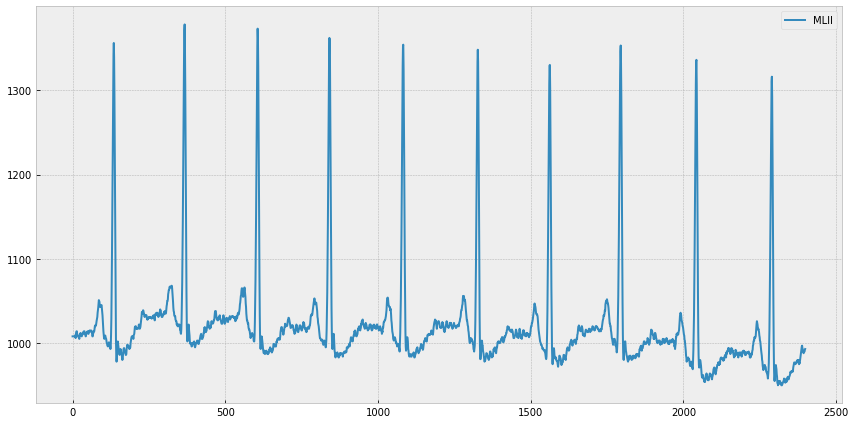

In [40]:
plt.figure(figsize=(12,6))
mit["MLII"].iloc[:2400].plot(legend=True, ax=plt.gca())
plt.tight_layout()

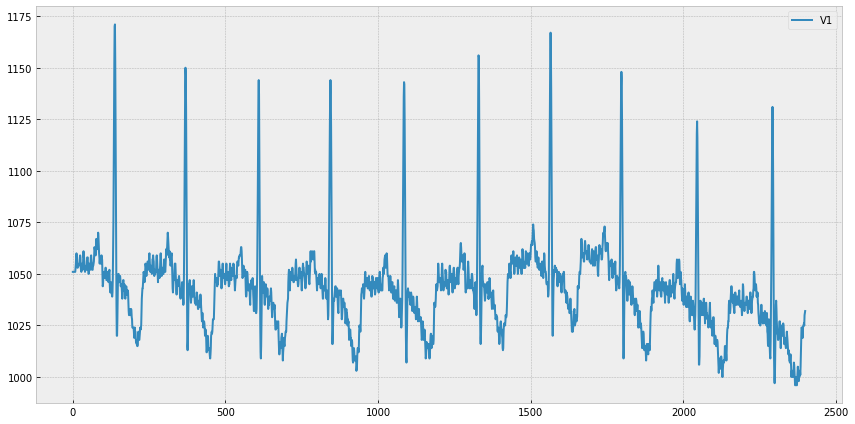

In [41]:
plt.figure(figsize=(12,6))
mit["V1"].iloc[:2400].plot(legend=True, ax=plt.gca())
plt.tight_layout()

As you can see, data has very strong temporal pattern. Failure in following this pattern is an indication of underlying medical condition and can be detected automatically.

In [42]:
annotations = pd.read_csv("234annotations.txt", sep="\s+")

In [43]:
annotations.head()

,Time,Sample,#,Type,Sub,Chan,Num,Aux
0,0:00.144,52,+,0,0,0,(N,NaN
1,0:00.375,135,N,0,0,0,NaN,NaN
2,0:01.017,366,N,0,0,0,NaN,NaN
3,0:01.683,606,N,0,0,0,NaN,NaN
4,0:02.336,841,N,0,0,0,NaN,NaN


In [44]:
annotations.columns = ["timestamp", "sample", "type", "sub", "chan", "num", "aux", "smth"]

In [45]:
annotations = annotations[annotations.columns[:-1]]

In [46]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  2764 non-null   object
 1   sample     2764 non-null   int64 
 2   type       2764 non-null   object
 3   sub        2764 non-null   int64 
 4   chan       2764 non-null   int64 
 5   num        2764 non-null   int64 
 6   aux        3 non-null      object
dtypes: int64(4), object(3)
memory usage: 151.3+ KB


In [47]:
annotations['aux'].value_counts()

(N       2
(SVTA    1
Name: aux, dtype: int64

There are many approaches to detection of structural anomalies. Depending on the signal, we can

- **construct some aggreagates for rolling windows,** and do the same thing we did with energy consumption. For example, we may calculate peak frequency, or power in some specific spectral band. This approach works well for signals, which do not have strict repetitive structure, but generally have some normal parameters. For example, for rotating (motors, generators, and so on) industrial equipment drift in peak frequency may indicate problems,
- **construct some forecasting model,** and look at large deviations between forecasts and real values. This works well for a) signals with autoregressive structure (energy consumption is a good example), and hence the model is some kind of AR model (AR, VAR, ARIMA, whatever works), b) for signals with clear and repetitive structure (ECG and EEG are good examples), and in this case we need to build a nonlinear model for forecasting.

Since we have a signal with very strict temporal pattern, we may try to model it and look at divergence between what model predicts (i.e. the temporal structure model catched) and real values.

We will take last 50 values (this number is a bit out of the blue, but if you look at signal, you'll see, that it should be ok). 
This will basicly allow us to convert our time series into a "point anomaly" problem

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

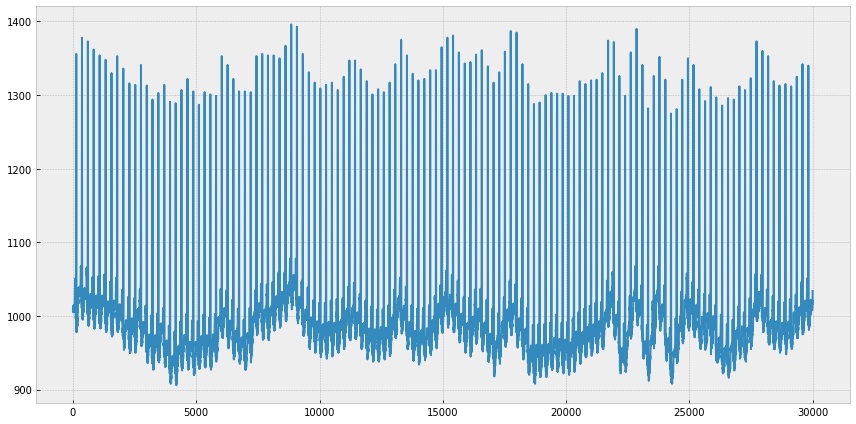

In [49]:
plt.figure(figsize=(12,6))
mit[:30000].MLII.plot()
plt.tight_layout()

We won't go into hyperparameters tuning, we only need to know, that our model cross-validaties.

In [50]:
WINDOW = 50
signal = mit[:15000]

In [51]:
features = {}

for i in signal.index[50:]:
    fts = (signal.loc[i-WINDOW:i-1, ["MLII", "V1"]]
           .reset_index(drop=True)
           .stack(dropna=False)
           .to_frame()
           .reset_index())
    fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
    features[i] = fts.loc[:, 0]
features = pd.DataFrame.from_dict(features, orient="index")

In [52]:
print(features.shape)
features.head()

(14950, 100)


,MLII_0,V1_0,MLII_1,V1_1,MLII_2,V1_2,MLII_3,V1_3,MLII_4,V1_4,...,MLII_45,V1_45,MLII_46,V1_46,MLII_47,V1_47,MLII_48,V1_48,MLII_49,V1_49
50,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1011,1052,1012,1056,1013,1058,1013,1058,1014,1058
51,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1012,1056,1013,1058,1013,1058,1014,1058,1014,1052
52,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1013,1058,1013,1058,1014,1058,1014,1052,1011,1052
53,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1013,1058,1014,1058,1014,1052,1011,1052,1011,1050
54,1008,1051,1008,1051,1008,1051,1008,1051,1009,1051,...,1014,1058,1014,1052,1011,1052,1011,1050,1012,1054


In [53]:
model = RandomForestRegressor(n_estimators=100, max_depth=4, n_jobs=4)
model.fit(features[:7500], signal.loc[features[:7500].index, "V1"])

RandomForestRegressor(max_depth=4, n_jobs=4)

In [54]:
print("CV MSE:", mean_squared_error(model.predict(features[7500:10000]),
                                    signal.loc[features[7500:10000].index, "V1"]))

CV MSE: 31.876956331176245


Ok, looks like it works just fine, let's look at forecasts:

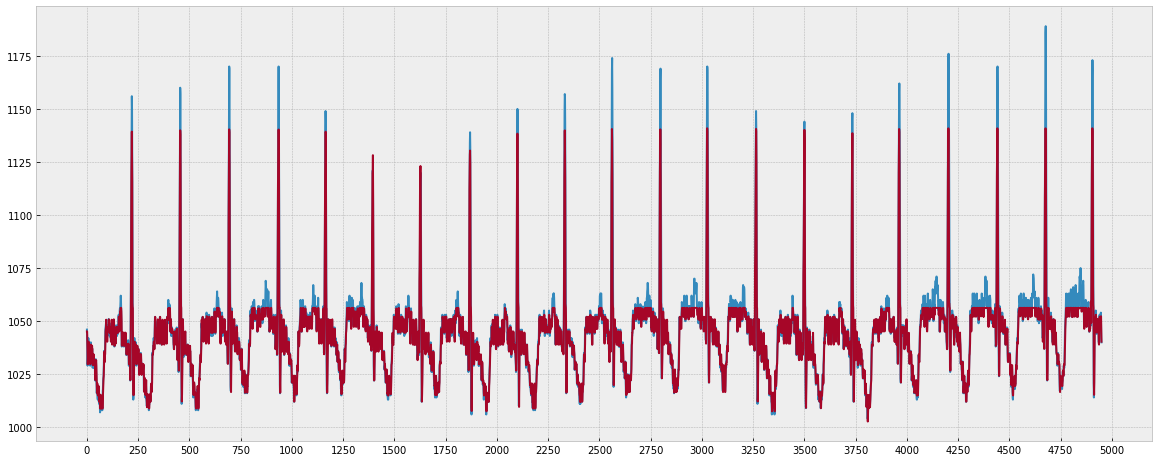

In [55]:
fig = plt.figure(figsize=(20, 8))
plt.plot(signal.loc[features[10000:].index, "V1"].values)
plt.plot(model.predict(features[10000:]))
plt.xticks(np.arange(0,5001, 250));

We see, that model is not ideal, but we do not plan to use it directly. Instead, we will look at longer time intervals:

In [56]:
indicator = pd.DataFrame(np.vstack([signal.loc[features[10000:].index, "V1"].values,
                                    model.predict(features[10000:])]).T,
                        columns = ["y_true", "y_pred"], index=features[10000:].index)

In [57]:
indicator["y_diff"] = (indicator["y_true"]-indicator["y_pred"]).abs()

<AxesSubplot:>

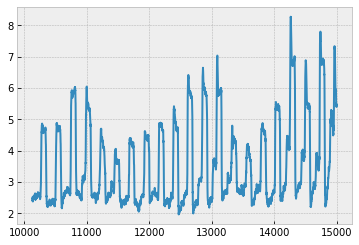

In [58]:
indicator["y_diff"].rolling(80).mean().plot()

Now, by thresholding the rolling averages difference between forecast and actual values, we can detect anomalous behaviour.

## Calculate features for a longer period of time, so that the model can be trained to better match the real signal.

In [59]:
## helper functions
from time import time


def create_features_based_on_window(data, window, cols):

    print('Calculating features...')
    t0 = time()
    features = {}

    for i in data.index[window:]:
        fts = (data.loc[i-window:i-1, cols ]
               .reset_index(drop=True)
               .stack(dropna=False)
               .to_frame()
               .reset_index())
        fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
        features[i] = fts.loc[:, 0]
    features = pd.DataFrame.from_dict(features, orient="index")
    
    print(f'calculating features (window {window}) took {time() - t0:.3f} sec))')
    return features



def run_rf_based_on_features(data, features, pred_col, train_idx):
    model = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=6)
    model.fit(features[:train_idx], data.loc[features[:train_idx].index, pred_col])
    
    return model


def evaluate_model(model, data, features, pred_col, train_idx, validation_idx, plot = True):
    
    mse = mean_squared_error(model.predict(features[train_idx:validation_idx]),
                                    data.loc[features[train_idx:validation_idx].index, pred_col])
    print("CV MSE: %.3f "%  mse)
    
    if plot:
        fig = plt.figure(figsize=(15,8))
        plt.plot(data.loc[features[validation_idx:].index, pred_col].values, alpha=0.5, label='real vlaues')
        plt.plot(model.predict(features[validation_idx:]), alpha=0.5, label = 'predictions')
        plt.legend()
    
    df_diff = pd.DataFrame(np.vstack([data.loc[features[validation_idx:].index, pred_col].values,
                                model.predict(features[validation_idx:])]).T,
                    columns = ["y_true", "y_pred"], index=features[validation_idx:].index)

    df_diff["y_diff"] = (df_diff["y_true"] - df_diff["y_pred"]).abs()

    
    return mse, df_diff
    

def plot_diff(diff_df, col, percentile):
    
    print(f'plotting diff, percentile = {percentile}')
    
    display(diff_df.head())
    fig = plt.figure(figsize=(15,8))
    diff_df[col].plot()
    plt.title(f' diff, percentile = {percentile}')
    
    # use the percentile to determine and plot anomalies
    threshold = np.percentile(diff_df[col], percentile)
    diff_ser = diff_df[col]
    print(f'threshold = {threshold:.3f}')
    anomalies = diff_ser[diff_ser > threshold ]
    
    plt.plot([diff_df.index.values[0], diff_df.index.values[0] + diff_df.shape[0]], [threshold, threshold], "g--", label = 'Threshold')
    plt.legend()

    # plot anomalies on top of diff graph
    plt.scatter(anomalies.index, anomalies, c = 'red')    
    
    
    
def plot_rolling_window_mean(df, window, col, percentile):
    
    print(f'plotting rolling mean diff, window = {window}, percentile = {percentile}')
    
    fig = plt.figure(figsize =(20,10))
    df[col].rolling(window).mean().plot()
    plt.title(f'rolling average diff, window = {window}, percentile = {percentile}')
    

    # use the percentile to determine and plot anomalies
    rolling_mean = df['y_diff'].rolling(window).mean()
    threshold = np.nanpercentile(rolling_mean, percentile)
    print(f'threshold = {threshold:.3f}')
    anomalies = rolling_mean[rolling_mean > threshold ]
    
    # plot anomalies
    plt.scatter(anomalies.index, anomalies, c = 'red')    
    
    plt.plot([df.index.values[0], df.index.values[0] + df.shape[0]], [threshold, threshold], "g--", label = 'Threshold')
    plt.legend()
    
    num_anomalies = anomalies.shape[0]
    percent_anomalies = num_anomalies / df.shape[0]
    print(f'{num_anomalies} anomalies, ({percent_anomalies:.3f}%)')



# return the window that produces the minimal mse on the cv set
def find_best_window(data, windows, cols, pred_col, train_idx, validation_idx, plot = True):

    mse_vec_rf = []

    for window in windows:

        print('create features...')
        features = create_features_based_on_window(data, window, cols)
        
        print('Run Random Forest model...')
        model = run_rf_based_on_features(data, features, pred_col, train_idx)
        
        print('Evaluate Random Forest model...')
        mse, _ = evaluate_model(model, data, features, pred_col, train_idx, validation_idx, plot = plot)
        mse_vec_rf.append(mse)

    best_window_rf = windows[np.argmin(mse_vec_rf)]

    print(f'minimal RF mse = {np.min(mse_vec_rf):.3f}, window = {best_window_rf}')

    fig = plt.figure(figsize = (10, 6))
    plt.plot(windows,mse_vec_rf, marker ='o')
    plt.title('Random Forest CV mse as function of window size')
    
    return best_window_rf

In [60]:
TRAIN = 7500
VALIDATION = 10000

create features...
Calculating features...
calculating features (window 25) took 30.437 sec))
Run Random Forest model...
Evaluate Random Forest model...
CV MSE: 10.501 
create features...
Calculating features...
calculating features (window 125) took 34.524 sec))
Run Random Forest model...
Evaluate Random Forest model...
CV MSE: 11.889 
create features...
Calculating features...
calculating features (window 250) took 39.239 sec))
Run Random Forest model...
Evaluate Random Forest model...
CV MSE: 12.687 
minimal RF mse = 10.501, window = 25


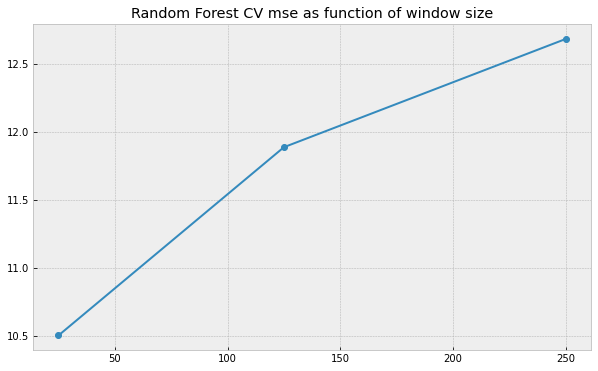

In [61]:
# Looking at the data it seems like the recurrence of peaks is around 250, let's try different values including 250 

windows_to_test = [25, 125, 250] # we tested more values but removed most to make the notebook run faster
cols_to_use = ["MLII", "V1"]
pred_col = "V1"
best_window = find_best_window(signal, windows_to_test, cols_to_use, pred_col, TRAIN, VALIDATION, plot = False)


In [62]:
signal.shape

(15000, 3)

***
Let's use the value that produced the lowest MSE. 
***

Calculating features...
calculating features (window 25) took 30.430 sec))
CV MSE: 10.535 


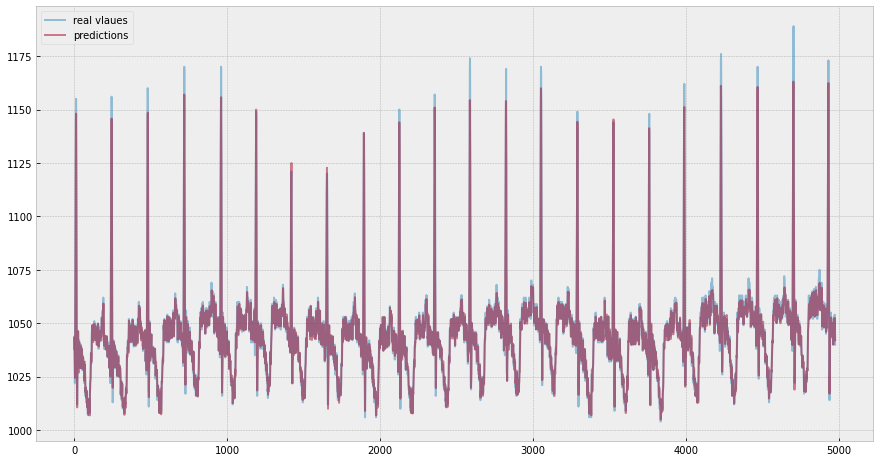

In [63]:
features = create_features_based_on_window(signal, best_window, cols_to_use)
features.head()
model = run_rf_based_on_features(signal, features, pred_col, TRAIN)
_, diff_df = evaluate_model(model, signal, features, pred_col, TRAIN, VALIDATION)

We can see we are able to predict the values trends pretty correctly, and most errors are at the peaks values.

##  Calculate differences. 


In [64]:
# mark anything at over the top X percentile of differences as anomlies
percentile =  widgets.FloatSlider(min=90, max = 99.99, step = 0.05, value = 99.75);

interact(plot_diff, diff_df = fixed(diff_df), col = fixed('y_diff'),
         percentile = percentile, continuous_update = False)


interactive(children=(FloatSlider(value=99.75, description='percentile', max=99.99, min=90.0, step=0.05), Outp…

<function __main__.plot_diff(diff_df, col, percentile)>

##  Are they are ok to serve as anomaly detection? Why we use rolling average instead of difference between forecast and actual values?

***

Whether or not to use the differences or a rolling average depends on the importance of detecting an anomaly vs. our tolerance for false alarms. If spotting an anomaly is crucial - we want to catch it as soon as it happens at any cost, then the differnces may serve us well, better then a rolling average which may delay the detection until the anomaly accumulates (as the average contains also pre-anonmaly information the anomlay affect is dimmed in the begining). 

The problem with this method is that it is prone to false alarms - a single differnce, high as it may be, may not always represent an anomaly but a random prediction error / noise (as our model is not perfect and may not grasp all the trends and seasonal effects which compose the data). This may stem because relying on a single differnce ignores the temporal context in which this differnce is embedded - it might be that a certain differnce is higher than a given threshold but at the same time previous differnces are less than the threshold but very close to the alledged anomaly. Using a rolling average encorporates context and stability, smoothes out noise, and ensures less false alarms, less variance, less complexity.
 
***

In [65]:
# let's use a widget to look at different rolling mean windows

# rolliing mean window
window = widgets.IntSlider(min=1, max = 100, value= 7, );

# mark anything at the top X percentile of differences as anomlies
percentile =  widgets.FloatSlider(min=90, max = 99.99, step = 0.1, value = 99.75);

interact(plot_rolling_window_mean, df = fixed(diff_df), window = window, col = fixed('y_diff'),
         percentile = percentile, continuous_update = False)


interactive(children=(IntSlider(value=7, description='window', min=1), FloatSlider(value=99.75, description='p…

<function __main__.plot_rolling_window_mean(df, window, col, percentile)>

## Implement the same approach (what we did from the title Structural anomalies) to the energy consumption problem.

In [66]:
# Load Energy and Temperture data

energy_data = load_energy_data()

data = temp_data.join(energy_data)
data.dropna(axis='index', inplace=True)

data.rename(columns={"Chicago": "temp"}, inplace=True)
display(data.head())


(66497, 1)
(45257, 2)
(45247, 2)


,temp,cons_mw
2012-10-01 13:00:00,284.010000,11426.0
2012-10-01 14:00:00,284.054691,11522.0
2012-10-01 15:00:00,284.177412,11574.0
2012-10-01 16:00:00,284.300133,11489.0
2012-10-01 17:00:00,284.422855,11309.0


In [67]:
TRAIN_EN = 22623
VALIDATION_EN = 30164

# helper functions

def plot_feature(data, feature, size):
    plt.figure(figsize=(12,6))
    data[feature].iloc[:size].plot(legend=True, ax=plt.gca())
    plt.tight_layout()
    
    
def plot_features(data, plot_size):
    plot_feature(data, 'temp', plot_size)
    plot_feature(data, 'cons_mw', plot_size)

In [68]:
# play with plot size to see patteens in the data

plot_size = widgets.IntSlider(min=10, max = 40000, step = 100, value=710 );
interact(plot_features, data = fixed(data), plot_size = plot_size, continuous_update = False)


interactive(children=(IntSlider(value=710, description='plot_size', max=40000, min=10, step=100), Output()), _…

<function __main__.plot_features(data, plot_size)>

***
by changing the plot size, we can see the different patterns in the data (daily, weekly, etc)
***

create features...
Calculating features...
calculating features (window 24) took 91.439 sec))
Run Random Forest model...
Evaluate Random Forest model...
CV MSE: 33133.549 
create features...
Calculating features...
calculating features (window 36) took 93.261 sec))
Run Random Forest model...
Evaluate Random Forest model...
CV MSE: 31752.765 
minimal RF mse = 31752.765, window = 36


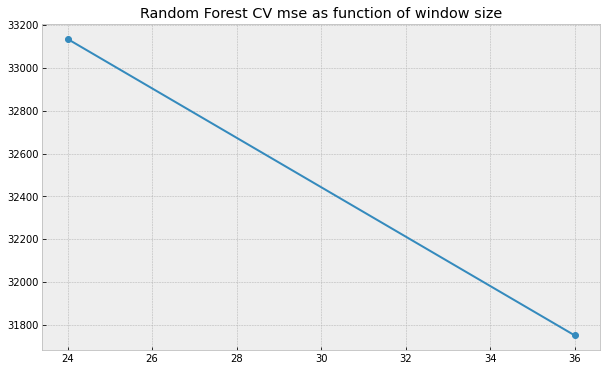

In [69]:
data.reset_index(inplace=True)

# let's try different windows: 168 = week, 336 = two weeks, 672 = 4 weeks
windows_to_test_en = [ 24, 36  ] # originally tested [ 12, 24, 36 , 48, 168, 250, 336, 672] 
cols_to_use_en = ["cons_mw", "temp"]
pred_col_en = "cons_mw"
best_window_en = find_best_window(data, windows_to_test_en, cols_to_use_en, 
                                  pred_col_en, TRAIN_EN, VALIDATION_EN, plot = False)


***

Let's use the window that produces the lowest mse on CV set (36 in this case)
***

Calculating features...
calculating features (window 36) took 93.792 sec))
CV MSE: 51574.580 


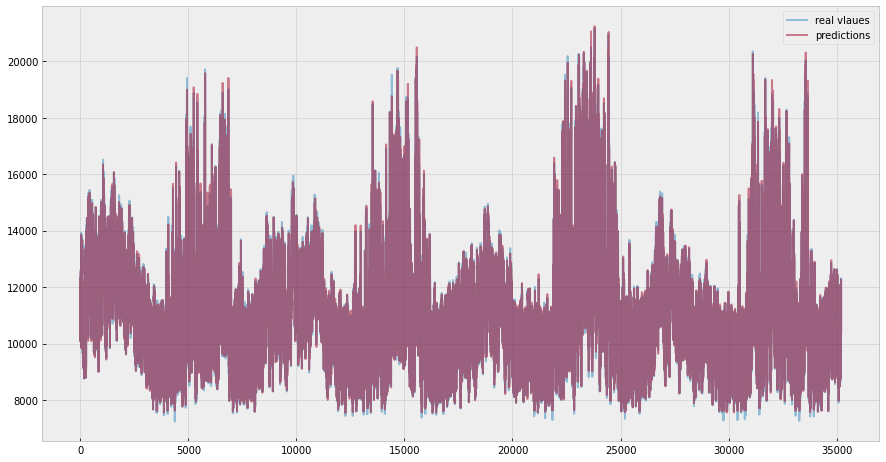

In [70]:
features_en = create_features_based_on_window(data, best_window_en, cols_to_use_en)
features_en.head()
model_en = run_rf_based_on_features(data, features_en, pred_col_en, TRAIN )
_, diff_df_en = evaluate_model(model_en, data, features_en, pred_col_en, TRAIN, VALIDATION)

***

Predictions seems not bad. Let's use them to find anomalies
***

In [83]:
# mark anything at the top X percentile of differences as anomlies
percentile =  widgets.FloatSlider(min=90, max = 99.99, step = 0.05, value = 99.75);

interact(plot_diff, diff_df = fixed(diff_df_en), col = fixed('y_diff'),
         percentile = percentile, continuous_update = False)


interactive(children=(FloatSlider(value=99.75, description='percentile', max=99.99, min=90.0, step=0.05), Outp…

<function __main__.plot_diff(diff_df, col, percentile)>

In [73]:
window = widgets.IntSlider(min=1, max = 500, value= 36 );

# mark anything at the top X percentile of differences as anomlies
percentile =  widgets.FloatSlider(min=90, max = 99.75, step = 0.1, value = 99.75);

# let's try different rolling windows
interact(plot_rolling_window_mean, df = fixed(diff_df_en), window = window, col = fixed('y_diff'),
         percentile = percentile, validation_idx = fixed(VALIDATION_EN), continuous_update = False)


interactive(children=(IntSlider(value=36, description='window', max=500, min=1), FloatSlider(value=99.75, desc…

<function __main__.plot_rolling_window_mean(df, window, col, percentile)>

In [74]:
def plot_rolling_average_anomalies_on_original_data(df, data, window, col, percentile):

    # plot rolling window mean differences
    plot_rolling_window_mean(df, window, col, percentile)
    
    
    # plot anomalies on original data
    
    fig = plt.figure(figsize =(20,10))

    data_for_new_df = [data.temp, data.cons_mw, df.y_diff]    
    headers = ["temp", "cons_mw", "y_diff"]

    new_df = pd.concat(data_for_new_df, axis=1, keys=headers)
    new_df.dropna(inplace = True)

    new_df['rolling_mean'] =  new_df['y_diff'].rolling(window).mean()

    threshold = np.nanpercentile(new_df['rolling_mean'], percentile)

    new_df['anomaly'] = 0
    new_df['anomaly'] = (new_df.rolling_mean > threshold ).astype(int)

    new_df.plot(x="cons_mw", y="temp", kind="scatter", s=2, alpha=0.7, c = 'y',
                         cmap=plt.cm.coolwarm_r, ax=plt.gca())

    new_df[new_df['anomaly'] == 1].plot(x="cons_mw", y="temp", kind="scatter", s=6, alpha=0.7,
                         c = 'b', ax=plt.gca())



In [77]:
window = widgets.IntSlider(min=1, max = 500, value= 10 );
percentile =  widgets.FloatSlider(min=90, max = 99.75, step = 0.1, value = 98.5);

interact(plot_rolling_average_anomalies_on_original_data, df = fixed(diff_df_en), data = fixed(data),
         window = window, col = fixed('y_diff'), percentile = percentile, continuous_update = False)

interactive(children=(IntSlider(value=10, description='window', max=500, min=1), FloatSlider(value=98.0, descr…

<function __main__.plot_rolling_average_anomalies_on_original_data(df, data, window, col, percentile)>

***

We can see we got a very different result when using the structural anomlies vs. the LOF / Isolation forest. We see that most anomalies are when the tempertures are high (over 285), and only a few when the tempertures are low. When we reduce the window to 1, we see alot more anomalies all over the drig, as without a rolling window, we get more noise classifed as anomalies.

***